# Pipeline for vehicle detection in video
1. Choose features to extract from train images
2. Transform each training image into feature vector
3. Use these labeled feature vectors to train classifier
4. Run classifer on entire video frames in patches

In [122]:
# import statements
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

#### Draw boxes function

In [2]:
# draw boxes after corners are detected
# boxes argument is an array of tuples, one for each box to draw, 2 corners in each box
# boxes = [((corner1), (corner2)), ((corner1), (corner2)), ((corner1), (corner2))]
# corners = (x,y)
def draw_boxes(img, boxes, color=(0,0,255), thick=6):
    # make copy of image
    draw_image = np.copy(img)
    # draw each box in boxes list
    for box in boxes:
        cv2.rectangle(draw_image, box[0], box[1], color, thick)
    
    return draw_image

VISUALIZATION

In [3]:
# # load images
# test_images = glob.glob('test_images/*')
# image_num = 3
# img = mpimg.imread(test_images[image_num])
# plt.imshow(img)

# boxes = [((800,400),(950, 510)), ((1020,400),(1275,510))]
# plt.imshow(draw_boxes(img, boxes))

#### Explore dataset

In [4]:
def explore_dataset(car_images, noncar_images):
    data_dict = {}
    data_dict['num_cars'] = len(car_images)
    data_dict['num_noncars'] = len(noncar_images)
    example_image = cv2.imread(car_image[0])
    data_dict['image_shape'] = example_image.shape
    data_dict['data_type'] = example_image.dtype
    return data_dict

# Feature Extraction

VISUALIZATION

+ Explore color spaces to use as features

In [8]:
# # load images
# colorspace_cutouts = glob.glob('colorspace_cutouts/*')
# test_images = colorspace_cutouts[6:]
# cars = colorspace_cutouts[:3]
# background = colorspace_cutouts[3:]
# cutout = cv2.imread(background[0])
# test_img = cv2.imread(test_images[2])


# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

# def plot3d(pixels, colors_rgb,
#         axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
#     """Plot pixels in 3D."""

#     # Create figure and 3D axes
#     fig = plt.figure(figsize=(8, 8))
#     ax = Axes3D(fig)

#     # Set axis limits
#     ax.set_xlim(*axis_limits[0])
#     ax.set_ylim(*axis_limits[1])
#     ax.set_zlim(*axis_limits[2])

#     # Set axis labels and sizes
#     ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
#     ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
#     ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
#     ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

#     # Plot pixel values with colors given in colors_rgb
#     ax.scatter(
#         pixels[:, :, 0].ravel(),
#         pixels[:, :, 1].ravel(),
#         pixels[:, :, 2].ravel(),
#         c=colors_rgb.reshape((-1, 3)), edgecolors='none')

#     return ax  # return Axes3D object for further manipulation


# # Read a color image
# img = cutout

# # Select a small fraction of pixels to plot by subsampling it
# scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
# img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# # Convert subsampled image to desired color space(s)
# img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
# img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
# img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)
# img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)
# img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# # show original image
# plt.imshow(img)

# # Plot and show
# plot3d(img_small_RGB, img_small_rgb)
# plt.show()

# plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
# plt.show()

# plot3d(img_small_HLS, img_small_rgb, axis_labels=list("HLS"))
# plt.show()

# plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"))
# plt.show()

#### Histogram of color channels

In [9]:
# find histograms of each color channel
def color_hist(img, nbins=32, bins_range=(0,256)):
    # find histograms of each color channel
    channel1 = np.histogram(img[:,:,0], nbins, bins_range)
    channel2 = np.histogram(img[:,:,1], nbins, bins_range)
    channel3 = np.histogram(img[:,:,2], nbins, bins_range)
    
    # concatenate into single feature vector
    hist_features = np.concatenate((channel1[0], channel2[0], channel3[0]))
    
    ## VISUALIZATION ##
    # calculate bin centers based on nbins and bins_range parameters
#     bin_edges = channel1[1]
#     bin_centers = (bin_edges[1:] + bin_edges[:len(bin_edges)-1]) / 2
#     return channel1, channel2, channel3, bin_centers, feature_vector

    return hist_features

VISUALIZATION

In [164]:
# # load images
# template_images = glob.glob('template_images/*')
# img = mpimg.imread(template_images[0])
# templates = template_images[1:]
# temp_img = mpimg.imread(templates[0])


# channel1, channel2, channel3, bin_centers, feature_vector = color_hist(temp_img)


# ## plot individual histograms ##
# fig = plt.figure(figsize=(12,3))
# plt.subplot(131)
# plt.bar(bin_centers, rhist[0])
# plt.xlim(0, 256)
# plt.title('R Histogram')
# plt.subplot(132)
# plt.bar(bin_centers, ghist[0])
# plt.xlim(0, 256)
# plt.title('G Histogram')
# plt.subplot(133)
# plt.bar(bin_centers, bhist[0])
# plt.xlim(0, 256)
# plt.title('B Histogram')
# fig.tight_layout()

#### Spatial binned features

In [60]:
# after selecting colorspace which best separates car pixels, use it to define a feature vector
def bin_spatial(img, size=(32,32)):
    bin_spatial_features = cv2.resize(img, size).ravel()
    return bin_spatial_features

VISUALIZATION

In [61]:
# ## remove .ravel() in function

# template_images = glob.glob('template_images/*')
# img = mpimg.imread(template_images[0])

# plt.imshow(img)
# plt.imshow(bin_spatial(img))

#### HOG gradient features

In [163]:
# add gradient vector to add structural information to the classifier
# accepts single color channel or grayscale
def hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True):
    # return list of [hog_features, hog_image]
    return_values = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), \
                       cells_per_block=(cell_per_block,cell_per_block), visualize=True, feature_vector=feature_vec, \
                       block_norm="L2-Hys")
    
    hog_features = return_values[0]
    hog_image = return_values[1]
    if vis:
        return hog_features, hog_image
    else:
        return hog_features

VISUALIZATION

C:\Users\Steve-PC\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


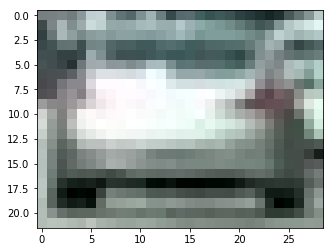

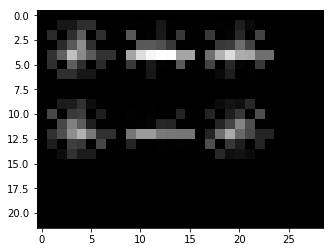

In [63]:
# # load images
# template_images = glob.glob('template_images/*')
# img = mpimg.imread(template_images[3])

# # parameters for hog function
# orient = 9
# pix_cell = 8
# cell_block = 2

# # convert to gray
# gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# # get hog_features and hog_image
# hog_feat, hog_img = hog_features(gray, orient, pix_cell, cell_block)

# # show images
# plt.figure()
# plt.imshow(img)

# plt.figure()
# plt.imshow(hog_img, cmap='gray')

#### EXTRACTION FUNCTION

In [161]:
# Use this function to extract all feature vectors from image to combine and scale
# Parameters must match parameters of all extraction functions called
# inputs list of image paths

def extract_features(img_list, orient, pix_per_cell, cell_per_block, color_space='RGB',\
                     nbins=32, bins_range=(0,256), size=(32,32), vis=False, feature_vec=True):
    
    # create features list, append vector for each image
    features_list = []
    for image in img_list:
        # read in image using cv2 = BGR
        img = cv2.imread(image)
        # convert to selected colorspace
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        else: 
            feature_image =  cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # create color histogram features
        hist_vector = color_hist(feature_image, nbins, bins_range)
        # create spatial binned features
        spatial_bin_vector = bin_spatial(feature_image, size)
        # create hog features
        gray = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
        hog_vector = hog_features(gray, orient, pix_per_cell, cell_per_block, vis, feature_vec)
        
        # concatenate features for each image
        image_features = np.concatenate((hist_vector, spatial_bin_vector, hog_vector))
        # append to list for each image
        features_list.append(image_features)
    return features_list

# CLASSIFICATION

#### PREPARE TRAINING DATA

In [152]:
# parameters for feature extraction function
orient = 15
pix_per_cell = 8
cell_per_block = 2
cspace = 'HSV'

In [153]:
# load training images
cars_train = glob.glob('vehicle_training_set/vehicles_smallset/*.jpeg')
non_cars_train = glob.glob('vehicle_training_set/non-vehicles_smallset/*.jpeg')

# extract feature vectors from training images
cars_features = extract_features(cars_train, orient, pix_per_cell, cell_per_block, color_space=cspace)
non_cars_features = extract_features(non_cars_train, orient, pix_per_cell, cell_per_block, color_space=cspace)

# create labels for each training set 1 == car, 0 == non-car
cars_labels = np.ones(len(cars_features))
non_cars_labels = np.zeros(len(non_cars_features))

# combine training data and labels
X = np.vstack((cars_features, non_cars_features)).astype(np.float64)
y = np.hstack((cars_labels, non_cars_labels))

# split train and test data
rand_state = np.random.randint(0,100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

## scale data
# FIT SCALER ON TRAINING SET ONLY
X_scaler = StandardScaler().fit(X_train)
# apply scaler to data
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)

#### BUILD CLASSIFIER

In [162]:
# define and train classifier
clf = LinearSVC()
clf.fit(scaled_X_train, y_train)

# check accuracy on test set
print('Accuracy of SVM on test set: ', clf.score(scaled_X_test, y_test))

# ground truth test
print('Predictions: ', clf.predict(scaled_X_test[:15]))
print('Ground trut: ', y_test[:15])

Accuracy of SVM on test set:  0.989247311828
Predictions:  [ 0.  0.  1.  1.  0.  1.  1.  0.  0.  1.  0.  1.  1.  1.  0.]
Ground trut:  [ 0.  0.  1.  1.  0.  1.  1.  0.  0.  1.  0.  1.  1.  1.  0.]


# SLIDING WINDOWS

In [166]:
'''
WINDOWS PER IMAGE FORMULA
windows_x = 1 + (image_width - window_width) / (window_width * overlap_proportion)
windows_y = 1 + (image_height - window_height) / (window_height * overlap_proportion)
total_windows = windows_x * windows_y

'''

'\nWINDOWS PER IMAGE FORMULA\nwindows_x = 1 + (image_width - window_image) / (window_width * overlap_proportion)\nwindows_y = 1 + (image_height - window_image) / (window_height * overlap_proportion)\ntotal_windows = windows_x * windows_y\n'

In [ ]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if not x_start_stop[0]:
        x_start_stop[0] = 0
    if not x_start_stop[1]:
        x_start_stop[1] = img.shape[1]
        
    if not y_start_stop[0]:
        y_start_stop[0] = 0
    if not y_start_stop[1]:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    xstep = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ystep = np.int(xy_window[1] * (1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    windows_x = np.int(1 + (xspan - xy_window[0]) / xstep)
    windows_y = np.int(1 + (yspan - xy_window[1]) / ystep)
    
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
    for ny in range(windows_y):
        for nx in range(windows_x):
            # Calculate each window position
            x_shift = xstep * nx
            y_shift = ystep * ny
            top_left = (x_start_stop[0] + x_shift, y_start_stop[0] + y_shift)
            bottom_right = (top_left[0] + xy_window[0], top_left[1] + xy_window[1])
            # Append window position to list
            window_list.append((top_left, bottom_right))
    # Return the list of windows
    return window_list